<a href="https://colab.research.google.com/github/MDYLL/Megafon_test/blob/master/Megafon_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Подключаем необходимые библиотеки.

In [147]:
import pandas as pd
import torch
import numpy as np

## 2. Загружаем данные и повехностно изучаем глубину проблемы.

In [298]:
df=pd.read_csv('C:/Users/User/Megafon/02_Data.csv',sep=';')

In [299]:
df.head()

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
0,5029,40798,158529599791,3.531111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0
1,7782,56870,158520145943,1.292900e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45.0,105.0
2,7794,32226,158521798391,3.519940e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0.0,60.0
3,7758,33528,158537830573,3.586270e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210.0,270.0
4,5060,17568,158510204039,3.524581e+14,8,1369252803586,37.1900,55.8308,500,OUTDOOR,180.0,240.0


In [300]:
df.shape[0]

174123

## 2.1. Посмотрим период, за который получены данные. Вдруг меня обманули с формулировкой задания.

In [301]:
pd.to_datetime(df.tstamp.min(), unit='ms'),pd.to_datetime(df.tstamp.max(), unit='ms')

(Timestamp('2013-05-22 20:00:00.974000'),
 Timestamp('2013-05-30 16:29:37.643000'))

## 3. Рассмотрим гипотезу - Персона с двумя симками должна регистрироваться в близкие временные интервалы в находящихся рядом вышках. Для определения вышек достаточно их географических координат. Все остальное выкидываем, тогда может мне хватит памяти ноутбука.


In [302]:
df=df.drop(['lac','cid','imei','event_type','max_dist','cell_type','start_angle','end_angle'],axis=1)

## 3.1. Слегка отнормируем время. Огромные числа меня пугают.

In [303]:
df.tstamp//=1000
df.tstamp-=df.tstamp.min(axis=0)

## 3.2. Посмотрим распределение регистраций по всему периоду данных. 30 мая сильно расходится с описанием задания.

In [304]:
period=df.tstamp.max(axis=0)//1000
y=[]
for i in range(1000):
  y.append(df.loc[(df.tstamp>i*period)&(df.tstamp<=(i+1)*period)].shape[0])

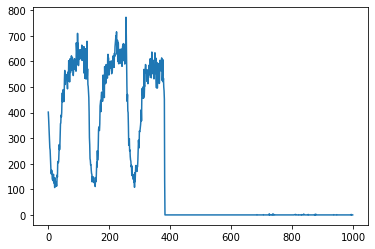

In [305]:
from matplotlib import pyplot as plt
plt.plot(y)
plt.show()

## 3.3. Ага, вот что Андрей имел в виду, когда говорил про "реальные данные". Судя по графику, достаточно будет рассмотреть данные только за первые 40% времени.

In [306]:
df=df.loc[df.tstamp<df.tstamp.max()*0.40]

In [307]:
period=df.tstamp.max(axis=0)//1000
y=[]
for i in range(1000):
  y.append(df.loc[(df.tstamp>i*period)&(df.tstamp<=(i+1)*period)].shape[0])

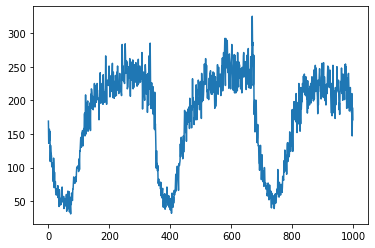

In [308]:
from matplotlib import pyplot as plt
plt.plot(y)
plt.show()

## 3.4. Глянем, сколько уникальных номеров в базе

In [159]:
unique_numbers=df['msisdn'].unique()
len(unique_numbers)

2359

## 3.5.Перебираем все пары номеров, кроме дублей (т.е. считаем пару (1,2) дублем (2,1)). Для каждой пары делаем выборку из датасета. Идем по строкам и ищем такие пары соседних строк, что номера телефонов в них разные. по каждой такой паре считаем евклидово расстояние по долготе и ширине, считая Землю плоской. Далее находим среднее и записываем его в словарь. Использование defaultdict нецелесообразно, но еще тратить 15 часов мне жаль. Если у Вас тоже нет желания ждать, то переходите к пункту 3.6. 

In [179]:
import collections
pair_dist=collections.defaultdict(float)
passed_time=0
for i in unique_numbers:
    print(passed_time/len(unique_numbers),end=' ')
    passed_time+=1
    for j in unique_numbers:
        if i<=j:
          continue
        df1=df.loc[(df.msisdn==i)|(df.msisdn==j)]
        current_msisdn=0
        dist=0
        num_iter=0
        for index,row in df1.iterrows():
            if current_msisdn==0:
                current_long=row.long
                current_lat=row.lat
                current_msisdn=row.msisdn
                continue
            if row.msisdn==current_msisdn:
                current_long=row.long
                current_lat=row.lat
                continue
            dist+=((row.long-current_long)**2+(row.lat-current_lat)**2)**0.5
            num_iter+=1
            current_msisdn=row.msisdn
            current_lat=row.lat
            current_long=row.long
        pair_dist[(i,j)]=dist/num_iter
        

0.0 0.000423908435777872 0.000847816871555744 0.001271725307333616 0.001695633743111488 0.00211954217888936 0.002543450614667232 0.002967359050445104 0.003391267486222976 0.0038151759220008477 0.00423908435777872 0.0046629927935565915 0.005086901229334464 0.005510809665112336 0.005934718100890208 0.00635862653666808 0.006782534972445952 0.0072064434082238235 0.007630351844001695 0.008054260279779568 0.00847816871555744 0.008902077151335312 0.009325985587113183 0.009749894022891056 0.010173802458668928 0.0105977108944468 0.011021619330224672 0.011445527766002543 0.011869436201780416 0.012293344637558287 0.01271725307333616 0.01314116150911403 0.013565069944891903 0.013988978380669776 0.014412886816447647 0.01483679525222552 0.01526070368800339 0.015684612123781264 0.016108520559559136 0.016532428995337006 0.01695633743111488 0.01738024586689275 0.017804154302670624 0.018228062738448497 0.018651971174226366 0.01907587961000424 0.01949978804578211 0.019923696481559984 0.020347604917337857

0.17380245866892752 0.17422636710470538 0.17465027554048326 0.17507418397626112 0.175498092412039 0.17592200084781687 0.17634590928359475 0.1767698177193726 0.1771937261551505 0.17761763459092836 0.17804154302670624 0.1784654514624841 0.17888935989826196 0.17931326833403985 0.1797371767698177 0.1801610852055956 0.18058499364137345 0.18100890207715134 0.1814328105129292 0.18185671894870709 0.18228062738448494 0.18270453582026283 0.1831284442560407 0.18355235269181858 0.18397626112759644 0.18440016956337432 0.18482407799915218 0.18524798643493007 0.18567189487070793 0.18609580330648579 0.18651971174226367 0.18694362017804153 0.18736752861381942 0.18779143704959728 0.18821534548537516 0.18863925392115302 0.1890631623569309 0.18948707079270877 0.18991097922848665 0.1903348876642645 0.1907587961000424 0.19118270453582026 0.19160661297159814 0.192030521407376 0.1924544298431539 0.19287833827893175 0.19330224671470964 0.1937261551504875 0.19415006358626535 0.19457397202204324 0.19499788045782

0.35184400169563373 0.3522679101314116 0.3526918185671895 0.35311572700296734 0.3535396354387452 0.3539635438745231 0.354387452310301 0.35481136074607883 0.3552352691818567 0.3556591776176346 0.3560830860534125 0.3565069944891903 0.3569309029249682 0.3573548113607461 0.3577787197965239 0.3582026282323018 0.3586265366680797 0.3590504451038576 0.3594743535396354 0.3598982619754133 0.3603221704111912 0.3607460788469691 0.3611699872827469 0.3615938957185248 0.3620178041543027 0.36244171259008057 0.3628656210258584 0.3632895294616363 0.36371343789741417 0.36413734633319206 0.3645612547689699 0.3649851632047478 0.36540907164052566 0.3658329800763035 0.3662568885120814 0.36668079694785927 0.36710470538363715 0.367528613819415 0.36795252225519287 0.36837643069097076 0.36880033912674864 0.3692242475625265 0.36964815599830436 0.37007206443408225 0.37049597286986014 0.37091988130563797 0.37134378974141585 0.37176769817719374 0.37219160661297157 0.37261551504874946 0.37303942348452734 0.3734633319

0.5320050869012294 0.5324289953370072 0.532852903772785 0.5332768122085629 0.5337007206443408 0.5341246290801187 0.5345485375158966 0.5349724459516745 0.5353963543874523 0.5358202628232301 0.536244171259008 0.5366680796947859 0.5370919881305638 0.5375158965663417 0.5379398050021196 0.5383637134378975 0.5387876218736752 0.5392115303094531 0.539635438745231 0.5400593471810089 0.5404832556167868 0.5409071640525647 0.5413310724883426 0.5417549809241204 0.5421788893598982 0.5426027977956761 0.543026706231454 0.5434506146672319 0.5438745231030098 0.5442984315387877 0.5447223399745655 0.5451462484103433 0.5455701568461212 0.5459940652818991 0.546417973717677 0.5468418821534549 0.5472657905892327 0.5476896990250106 0.5481136074607885 0.5485375158965663 0.5489614243323442 0.5493853327681221 0.5498092412039 0.5502331496396778 0.5506570580754557 0.5510809665112336 0.5515048749470114 0.5519287833827893 0.5523526918185672 0.552776600254345 0.5532005086901229 0.5536244171259008 0.5540483255616787 0.

0.7164052564646036 0.7168291649003815 0.7172530733361594 0.7176769817719373 0.7181008902077152 0.7185247986434931 0.7189487070792708 0.7193726155150487 0.7197965239508266 0.7202204323866045 0.7206443408223824 0.7210682492581603 0.7214921576939382 0.7219160661297159 0.7223399745654938 0.7227638830012717 0.7231877914370496 0.7236116998728275 0.7240356083086054 0.7244595167443832 0.7248834251801611 0.7253073336159389 0.7257312420517168 0.7261551504874947 0.7265790589232726 0.7270029673590505 0.7274268757948283 0.7278507842306062 0.7282746926663841 0.7286986011021619 0.7291225095379398 0.7295464179737177 0.7299703264094956 0.7303942348452734 0.7308181432810513 0.7312420517168292 0.731665960152607 0.7320898685883849 0.7325137770241628 0.7329376854599406 0.7333615938957185 0.7337855023314964 0.7342094107672743 0.7346333192030522 0.73505722763883 0.7354811360746079 0.7359050445103857 0.7363289529461636 0.7367528613819415 0.7371767698177194 0.7376006782534973 0.7380245866892751 0.7384484951250

0.9003815175922001 0.900805426027978 0.9012293344637559 0.9016532428995337 0.9020771513353115 0.9025010597710894 0.9029249682068673 0.9033488766426452 0.9037727850784231 0.904196693514201 0.9046206019499788 0.9050445103857567 0.9054684188215345 0.9058923272573124 0.9063162356930903 0.9067401441288682 0.907164052564646 0.9075879610004239 0.9080118694362018 0.9084357778719796 0.9088596863077575 0.9092835947435354 0.9097075031793133 0.9101314116150911 0.910555320050869 0.9109792284866469 0.9114031369224248 0.9118270453582026 0.9122509537939805 0.9126748622297584 0.9130987706655362 0.9135226791013141 0.913946587537092 0.9143704959728699 0.9147944044086477 0.9152183128444256 0.9156422212802034 0.9160661297159813 0.9164900381517592 0.9169139465875371 0.917337855023315 0.9177617634590929 0.9181856718948707 0.9186095803306485 0.9190334887664264 0.9194573972022043 0.9198813056379822 0.9203052140737601 0.920729122509538 0.9211530309453159 0.9215769393810936 0.9220008478168715 0.9224247562526494 

## 3.5.1. Посмотрим, что у нас произошло за последние 15 часов. Проверим длину словаря, среднее значение расстояния и расстояние из обучаемой выборки. 

In [186]:
len(pair_dist),2359*2358/2

(2781261, 2781261.0)

In [193]:
total_value=0
for el in pair_dist.keys():
    total_value+=pair_dist[el]

In [194]:
total_value/len(pair_dist)

0.5249626612437417

In [195]:
pair_dist[(158530067653,158528861653)]

0.21167113604971524

## 3.5.2. Положим всю информацию в тензор и запишем его.

In [197]:
x=torch.zeros(2781261)
idx=0
for el in pair_dist.keys():
    x[idx]=pair_dist[el]
    idx+=1

In [199]:
torch.save(x,'pair_dist.pt')

## 3.6.  Если Вы были со мной последние 15 часов, то пропустите следующую ячейку. Иначе подгрузите тензор

In [ ]:
x=torch.load('pair_dist.pt')

## 4. Теперь добавим признак парности телефонов из обучающей выборки. Для начала закачаем слегка подредактированный файл.

In [ ]:
df=pd.read_csv('C:/Users/User/Megafon/facts.csv',sep=';')

## 4.1. Положим в лист все пары, соблюдая очередность из 15-часового цикла, - сначала бОльший номер, затем меньший.

In [ ]:
label=[]
for row in df.iterrows():
  label.append((max(row[1][0],row[1][1]),min(row[1][0],row[1][1])))

## 4.2. Положим все в тензор, опять же с соблюдением очередности.

In [219]:
x_label=torch.zeros(x.shape)

In [220]:
idx=0
dist=[]
for i in unique_numbers:
    for j in unique_numbers:
        if i<=j:
          continue
        if (i,j) in label:
            x_label[idx]=1
        idx+=1

In [233]:
dist_with_labels=torch.zeros((x.shape[0],2))
dist_with_labels[:,0]=x
dist_with_labels[:,1]=x_label

## 4.3. Лучи благодарности и любви StackOverflow, который научил меня сортировать тензоры по столбцу

In [234]:
dist_with_labels=dist_with_labels[dist_with_labels[:,0].argsort()]

In [239]:
dist_with_labels[-1][0]

tensor(4.4590)

## 4.4. В соответствии с гипотезой посчитаем TPR и FPR для тресхолдов с интервалом в 0.001 градуса. Я понимаю, что складывать квадрат широты и долготы с точки зрения геометрии ужас-ужас, но для этой задачи пойдет.

In [ ]:
total_positive=sum(x_label)
total_negative=x.shape[0]-total_positive

In [295]:
tpr=[]
fpr=[]
delta=0.001
dist=0.0
tp=0
all=0
while (dist<=dist_with_labels[-1][0]):
    y=dist_with_labels[dist_with_labels[:,0]<dist]
    y=y[y[:,0]>=dist-delta]
    tp+=sum(y[:,1])
    fn=total_positive-tp
    tpr.append(tp/(tp+fn))
    all+=y.shape[0]
    fpr.append((all-tp)/total_negative)
    dist+=delta

## 4.5. Построим ROC curve

In [296]:
fpr1=[i.item() for i in fpr]
tpr1=[i.item() for i in tpr]

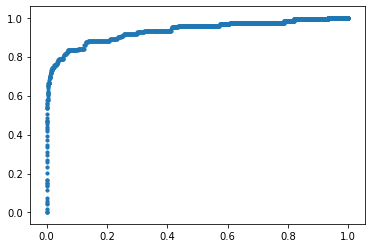

In [297]:
plt.scatter(fpr1,tpr1,s=10)
plt.show()

## 5. Получилась очень красивая картинка, гораздо лучше примеров с Вики. Теперь можно, ткнув в любую точку кривой, выбрать FPR(TPR) и, прогнав цикл еще раз, получить нужный тресхолд.